In [1]:
import matplotlib.patches as patches
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np
from matplotlib import gridspec
import matplotlib as mpl
from matplotlib.offsetbox import AnnotationBbox, DrawingArea
from matplotlib.patches import Wedge
from matplotlib.lines import Line2D
import matplotlib.ticker as mticker

landmask = xr.open_dataset("F:/008_Screening_data_CMIP6/Masks/landmask.nc")['mask']

def add_unified_colorbar(fig, ax, mesh, label):
    pos = ax.get_position()

    # 颜色条定位参数：在子图底部下方固定距离，宽度为子图宽度70%
    cax_height = 0.01  # 颜色条高度（固定值）
    cax_width = pos.width * 0.7  # 颜色条宽度
    cax_y = pos.y0 - cax_height - 0.035  # 距离子图底部固定距离
    cax_x = pos.x0 + pos.width * 0.15  # 水平居中

    # 创建颜色条坐标轴
    cax = fig.add_axes([cax_x, cax_y, cax_width, cax_height])

    # 添加颜色条
    cbar = fig.colorbar(mesh, cax=cax, orientation='horizontal', extend='both')
    # 在 colorbar 上方左侧添加文字
    # cbar.ax.text(0, 1.2, "Decrease", ha='left', va='bottom', fontsize=16, transform=cbar.ax.transAxes)

    # 在 colorbar 上方右侧添加文字
    # cbar.ax.text(1, 1.2, "Increase", ha='right', va='bottom', fontsize=16, transform=cbar.ax.transAxes)
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label(label, fontsize=14)

    return cbar

# 绘制矩形地图（输入矩形四角坐标）
def draw_rectange_map(hotpoint, dd, fig=False, ax=None, extent=[-180, 180, -60, 90], linewi=1, lines='-'):
    if fig == False:
        fig = plt.figure(figsize=(12.27, 6.69), dpi=100, facecolor='white')
        ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())
        ax.set_extent(extent, crs=ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.LAND, facecolor='#FFE9B5')

    ax.plot([hotpoint[dd][2], hotpoint[dd][3]], [hotpoint[dd][1], hotpoint[dd][1]], transform=ccrs.PlateCarree(), linewidth=linewi,
            color='k', ls=lines)
    ax.plot([hotpoint[dd][2], hotpoint[dd][3]], [hotpoint[dd][0], hotpoint[dd][0]], transform=ccrs.PlateCarree(), linewidth=linewi,
            color='k', ls=lines)
    ax.plot([hotpoint[dd][2], hotpoint[dd][2]], [hotpoint[dd][0], hotpoint[dd][1]], transform=ccrs.PlateCarree(), linewidth=linewi,
            color='k', ls=lines)
    ax.plot([hotpoint[dd][3], hotpoint[dd][3]], [hotpoint[dd][0], hotpoint[dd][1]], transform=ccrs.PlateCarree(), linewidth=linewi,
            color='k', ls=lines)

def draw_hotpoint_labels(hotpoint_label, fig=None, ax=None, fontsize=16, fontweight='bold', color='black'):
    """
    在指定坐标位置标注区域名称

    参数:
    hotpoint_label: 包含区域名称和标注坐标的字典
    fig: 图形对象
    ax: 坐标轴对象
    fontsize: 字体大小
    fontweight: 字体粗细
    color: 文字颜色
    """
    for region_name, coords in hotpoint_label.items():
        lat, lon = coords
        ax.text(lon, lat, region_name,
                fontsize=fontsize,
                fontweight=fontweight,
                color=color,
                ha='center',      # 水平对齐方式
                va='center',      # 垂直对齐方式
                transform=ccrs.PlateCarree(),)

In [2]:
def plot_supplementary_fig20a(fig, ax):
    obs_rh = xr.open_dataset("E:/Drought_And_SOC/000_observasion_data_ERA5/01_preprocessed_data/merged_rh_data.nc")['Rh']
    MMEM_rh = xr.open_dataset("F:/007-1_MEM_data_CMIP6/raw/rh_MMEM.nc")['ssp126_rh'].sel(time=slice('1985-01-01', '2014-12-31')).mean(dim='time')
    MMWM_rh = xr.open_dataset("F:/007-2_MMWM_data_CMIP6/raw/rh_MMWM.nc")['ssp126_rh'].sel(time=slice('1985-01-01', '2014-12-31')).mean(dim='time')

    ssp126_MMEM = xr.open_dataset("F:/007-1_MEM_data_CMIP6/raw/rh_MMEM.nc")['ssp126_rh'].sel(time=slice('2070-01-01', '2099-12-31')).mean(dim='time')
    ssp126_MMWM = xr.open_dataset("F:/007-2_MMWM_data_CMIP6/raw/rh_MMWM.nc")['ssp126_rh'].sel(time=slice('2070-01-01', '2099-12-31')).mean(dim='time')

    ssp585_MMEM = xr.open_dataset("F:/007-1_MEM_data_CMIP6/raw/rh_MMEM.nc")['ssp585_rh'].sel(time=slice('2070-01-01', '2099-12-31')).mean(dim='time')
    ssp585_MMWM = xr.open_dataset("F:/007-2_MMWM_data_CMIP6/raw/rh_MMWM.nc")['ssp585_rh'].sel(time=slice('2070-01-01', '2099-12-31')).mean(dim='time')

    # 展示模拟值与真实值对比
    difference = MMWM_rh.where(landmask == 1) - obs_rh.where(landmask == 1)
    # 设置地图投影和范围
    ax.set_extent([-170, 180, -60, 90], crs=ccrs.PlateCarree())
    
    # 获取数据范围
    lons = difference.lon.values
    lats = difference.lat.values

    lon_min, lon_max = difference.lon.min().values, difference.lon.max().values
    lat_min, lat_max = difference.lat.min().values, difference.lat.max().values

    # 计算每个像素的大小
    d_lon = (lon_max - lon_min) / len(difference.lon)
    d_lat = (lat_max - lat_min) / len(difference.lat)

    # 设置colormap和norm
    cmap = plt.get_cmap("RdBu_r")
    vmin = difference.min().item()
    vmax = difference.max().item()
    norm = plt.Normalize(-1, 1)

    # 创建圆角矩形标记
    for i in range(len(lats)):
        for j in range(len(lons)):
            # 跳过海洋/无效值
            if np.isnan(difference[i, j].item()):
                continue

            value = difference[i, j].item()

            # 创建圆角矩形路径
            patch = patches.FancyBboxPatch(
                    (lons[j] - d_lon/2, lats[i] - d_lat/2),
                    d_lon, d_lat,
                    edgecolor='none',
                    facecolor=cmap(norm(value)),
                    alpha=1,
                    boxstyle="round,pad=0.05,rounding_size=0.3",
                    transform=ccrs.PlateCarree(),
                    zorder = 1
                )
            ax.add_patch(patch)

    # 添加地理要素
    ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='black', linewidth=0.5)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.set_title("Difference Between CMIP6 & Observation", fontsize=16, pad=15)

    # 优化网格线
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,
        linewidth=0.5, color='gray', alpha=0.5, linestyle='--'
    )
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 20, 'color': 'black'}
    gl.ylabel_style = {'size': 20, 'color': 'black'}

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array(np.array([]))  # 空数组

    cbar = add_unified_colorbar(fig, ax, sm, "")
    cbar.set_ticks(np.arange(-1, 1.1, 0.2))

    # 添加图例标识
    ax.text(-0.08, 1.08, 'c',
            fontweight='bold',
            transform=ax.transAxes,
            fontsize=22,
            va='top', ha='left',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

In [3]:
def plot_supplementary_fig20b(
    fig, ax,
    stem_width=2.0,          # 竖线粗细
    stem_alpha=0.9,          # 竖线透明度
    marker_size=80,          # 圆圈大小（scatter 的 s）
    marker_edgewidth=2.0,    # 圆圈边宽
    offset=0.08,             # Total/Direct 的横向错位
    y_pad_ratio=0.12,        # y 轴顶部留白比例
    colors=None,              # 自定义颜色字典，例如 {"Total":"#1f77b4","Direct":"#ff7f0e"}
    cat_spacing=0.001,     # 情景间距(默认<1，让图“收窄”)
    offset_frac=0.16,     # Total/Direct 与情景中心的相对偏移(相对 cat_spacing)
    x_margin=0.1         # 轴两端水平留白比例(0~1)
):
    """
    在传入的 ax 所占矩形内，切分出 1x3 子轴绘制竖向棒棒糖图（PR/MRSO/TS）。
    不改变全局布局，不影响 5a/5b 的空间占用。
    """
    from matplotlib.gridspec import GridSpecFromSubplotSpec
    # ===== 颜色 =====
    if colors is None:
        colors = {"Total": "#1f77b4", "Direct": "#ff7f0e"}

    # ===== 读取数据 =====
    HIST = xr.open_dataset("F:/010_SEM_result_CMIP6/GPT/SEM_historical_rh_full_effects.nc")
    SSP126 = xr.open_dataset("F:/010_SEM_result_CMIP6/GPT/SEM_ssp126_rh_full_effects.nc")
    SSP585 = xr.open_dataset("F:/010_SEM_result_CMIP6/GPT/SEM_ssp585_rh_full_effects.nc")

    def abs_mean(ds, var):
        return ds[var].mean().item()

    scenarios = ['Historical', 'SSP1-2.6', 'SSP5-8.5']
    data = {
        "PR": {
            "Total": [abs_mean(HIST, "rh_pr_total"),
                      abs_mean(SSP126, "rh_pr_total"),
                      abs_mean(SSP585, "rh_pr_total")],
            "Direct": [abs_mean(HIST, "rh_pr_direct"),
                       abs_mean(SSP126, "rh_pr_direct"),
                       abs_mean(SSP585, "rh_pr_direct")]
        },
        "MRSO": {
            "Total": [abs_mean(HIST, "rh_mrso_total"),
                      abs_mean(SSP126, "rh_mrso_total"),
                      abs_mean(SSP585, "rh_mrso_total")],
            "Direct": [abs_mean(HIST, "rh_mrso_direct"),
                       abs_mean(SSP126, "rh_mrso_direct"),
                       abs_mean(SSP585, "rh_mrso_direct")]
        },
        "TS": {
            "Total": [abs_mean(HIST, "rh_ts_total"),
                      abs_mean(SSP126, "rh_ts_total"),
                      abs_mean(SSP585, "rh_ts_total")],
            "Direct": [abs_mean(HIST, "rh_ts_direct"),
                       abs_mean(SSP126, "rh_ts_direct"),
                       abs_mean(SSP585, "rh_ts_direct")]
        }
    }

    # ===== 统一 y 轴范围（0 到 max+pad）=====
    all_vals = []
    for v in data.values():
        all_vals += v["Total"] + v["Direct"]
    ymin = float(np.nanmin(all_vals)) if len(all_vals) else 0.0
    ymax = float(np.nanmax(all_vals)) if len(all_vals) else 1.0
    ypad = y_pad_ratio * ymax
    y_min, y_max = ymin - ypad, ymax + ypad

    # ===== 在 ax 的 SubplotSpec 内再切分 1x3 子轴（不改变外部版式）=====
    ss = ax.get_subplotspec()             # ax 对应的 SubplotSpec
    fig.delaxes(ax)                       # 删除原 ax（避免重叠）
    subgs = GridSpecFromSubplotSpec(1, 3, subplot_spec=ss, wspace=0.1)  # 仅在此矩形内分 1x3

    var_order = ["PR", "MRSO", "TS"]
    titles = {
        "PR": "Precipitation",
        "MRSO": "Soil Moisture",
        "TS": "Surface Temperature"
    }

    axes = []
    for i, var in enumerate(var_order):
        ax_i = fig.add_subplot(subgs[0, i], sharey=axes[0] if axes else None)
        axes.append(ax_i)

        totals = data[var]["Total"]
        directs = data[var]["Direct"]

        x = np.arange(len(scenarios)) * cat_spacing
        x_total  = x - offset_frac * cat_spacing
        x_direct = x + offset_frac * cat_spacing

        # 竖线（stem）
        for xx, v in zip(x_total, totals):
            ax_i.vlines(xx, 0, v, color=colors["Total"], linewidth=stem_width, alpha=stem_alpha)
        for xx, v in zip(x_direct, directs):
            ax_i.vlines(xx, 0, v, color=colors["Direct"], linewidth=stem_width, alpha=stem_alpha)

        # 顶部圆圈（默认空心）
        ax_i.scatter(x_total, totals, s=marker_size, facecolors="white",
                     edgecolors=colors["Total"], linewidths=marker_edgewidth, zorder=3, label="Total Effect")
        ax_i.scatter(x_direct, directs, s=marker_size, facecolors="white",
                     edgecolors=colors["Direct"], linewidths=marker_edgewidth, zorder=3, label="Direct Effect")

        # 数值标注（相对 ymax 留白）
        for xx, v in zip(x_total, totals):
            ax_i.text(xx, v + 0.05 * ymax, f"{v:.3f}", ha="center", va="bottom", fontsize=10, color=colors["Total"])
        for xx, v in zip(x_direct, directs):
            ax_i.text(xx, v + 0.05 * ymax, f"{v:.3f}", ha="center", va="bottom", fontsize=10, color=colors["Direct"])

            # 添加横轴参考线
        ax_i.axhline(y=0, color='k', linewidth=0.8)

        # 轴样式
        ax_i.margins(x=x_margin)
        ax_i.set_xticks(x)
        ax_i.set_xticklabels(scenarios, rotation=0, fontsize=12)
        ax_i.set_ylim(y_min, y_max)
        ax_i.grid(axis="y", alpha=0.3, linestyle="--", linewidth=0.8)
        ax_i.set_title(titles[var], pad=8)
        ax_i.set_xlabel("Scenarios", fontsize=12)
        ax_i.tick_params(axis="y", labelsize=12)
        # 设置上下边框与右边框不显示
        ax_i.spines['top'].set_visible(False)
        ax_i.spines['right'].set_visible(False)

        pos = ax_i.get_position()
        ax_i.set_position([pos.x0+0.01, pos.y0, pos.width, pos.height])

    # y 轴只在第一个子轴显示
    axes[0].set_ylabel("Effect Value", fontsize=12)
    # 添加图例标识
    axes[0].text(-0.01, 1.1, 'a',
            fontweight='bold',
            transform=ax.transAxes,
            fontsize=22,
            va='top', ha='left',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    for ax_i in axes[1:]:
        ax_i.label_outer()  # 隐藏共享 y 轴的重复标签

    handles, labels = axes[0].get_legend_handles_labels()
    axes[0].legend(handles, labels, frameon=False, loc="upper left", fontsize=12)
    return None

In [4]:
def plot_supplementary_fig20c(fig, ax):
    # === 1) 数据：SSP5-8.5 - Historical ===
    SSP585_SOC_STM = xr.open_dataset("F:/010_SEM_result_CMIP6/GPT/SEM_ssp585_rh_full_effects.nc")
    SSP585_SOC_MRSO_TOTAL = SSP585_SOC_STM['rh_mrso_total']

    SSP126_SOC_STM = xr.open_dataset("F:/010_SEM_result_CMIP6/GPT/SEM_ssp126_rh_full_effects.nc")
    SSP126_SOC_MRSO_TOTAL = SSP126_SOC_STM['rh_mrso_total']

    HIST_SOC_STM = xr.open_dataset("F:/010_SEM_result_CMIP6/GPT/SEM_historical_rh_full_effects.nc")
    HIST_SOC_MRSO_TOTAL = HIST_SOC_STM['rh_mrso_total']

    # 设置地图投影和范围
    ax.set_extent([-170, 180, -60, 90], crs=ccrs.PlateCarree())

    # 获取数据范围
    lons = SSP585_SOC_MRSO_TOTAL.lon.values
    lats = SSP585_SOC_MRSO_TOTAL.lat.values

    lon_min, lon_max = SSP585_SOC_MRSO_TOTAL.lon.min().values, SSP585_SOC_MRSO_TOTAL.lon.max().values
    lat_min, lat_max = SSP585_SOC_MRSO_TOTAL.lat.min().values, SSP585_SOC_MRSO_TOTAL.lat.max().values

    # 计算每个像素的大小
    d_lon = (lon_max - lon_min) / len(SSP585_SOC_MRSO_TOTAL.lon)
    d_lat = (lat_max - lat_min) / len(SSP585_SOC_MRSO_TOTAL.lat)

    # 设置colormap和norm
    cmap = plt.get_cmap("RdBu_r")
    vmin = SSP585_SOC_MRSO_TOTAL.min().item()
    vmax = SSP585_SOC_MRSO_TOTAL.max().item()
    norm = plt.Normalize(-1, 1)

    # 创建圆角矩形标记
    for i in range(len(lats)):
        for j in range(len(lons)):
            # 跳过海洋/无效值
            if np.isnan(SSP585_SOC_MRSO_TOTAL[i, j].item()):
                continue

            value = SSP585_SOC_MRSO_TOTAL[i, j].item()

            # 创建圆角矩形路径
            patch = patches.FancyBboxPatch(
                    (lons[j] - d_lon/2, lats[i] - d_lat/2),
                    d_lon, d_lat,
                    edgecolor='none',
                    facecolor=cmap(norm(value)),
                    alpha=1,
                    boxstyle="round,pad=0.05,rounding_size=0.3",
                    transform=ccrs.PlateCarree(),
                    zorder = 1
                )
            ax.add_patch(patch)

    hotpoint = {
        "AMZ-SE": [-24.1,  1.5,  -60.5, -34.5],
        "NAMS"  : [ 18.3, 34.9, -119.9, -78.7],
        "AUS"   : [-38.8, -10.2, 114.1, 154.5],
        "SE-CHN": [ 21.0, 34.0,   99.4, 123.1],
        "S-AF"  : [-35.0, -12.8,   9.7,  50.6],
        "MED"   : [ 35.2, 56.1,  -12.5,  70.3],
    }
    hotpoint_label = {
        "AMZ-SE": [ 5,   -35],
        "NAMS"  : [26.6, -133],
        "AUS"   : [-24.5, 104],
        "SE-CHN": [27.5, 140],
        "S-AF"  : [-40,   30.2],
        "MED"   : [45.7,  -25],
    }

    for k in hotpoint.keys():
        draw_rectange_map(hotpoint, k, fig=fig, ax=ax, extent=[-180, 180, -60, 90])

    # 全局 x 轴范围（去极端值，观感稳）
    valid_all = np.concatenate([
        SSP585_SOC_MRSO_TOTAL.values[np.isfinite(SSP585_SOC_MRSO_TOTAL.values)],
        SSP585_SOC_MRSO_TOTAL.values[np.isfinite(SSP585_SOC_MRSO_TOTAL.values)]
    ])
    xmin = np.nanpercentile(valid_all, 1) if valid_all.size else -1.0
    xmax = np.nanpercentile(valid_all, 99) if valid_all.size else  1.0
    if xmin == xmax:
        xmin, xmax = xmin - 1e-3, xmax + 1e-3

    # 辅助：经纬度 -> 轴坐标（用于把小图放海面空白处）
    def lonlat_to_axesxy(lon, lat):
        pt = ax.projection.transform_points(
            ccrs.PlateCarree(), np.asarray([lon]), np.asarray([lat])
        )[0, :2]
        disp = ax.transData.transform(pt)
        axxy = ax.transAxes.inverted().transform(disp)
        return float(axxy[0]), float(axxy[1])

    # 每个热点的小图偏移（轴坐标），尽量放海上空白区域
    inset_offset = {
        "AMZ-SE": (+0.07, -0.16),  # 南大西洋
        "NAMS"  : (-0.07, -0.10),  # 北大西洋
        "AUS"   : (-0.12, +0.06),  # 塔斯曼海
        "SE-CHN": (+0.11, -0.04),  # 西北太平洋
        "S-AF"  : (+0.07, -0.09),  # 印度洋
        "MED"   : (-0.17, -0.07),  # 东北大西洋
    }
    inset_w, inset_h = 0.10, 0.12

    col_585, col_126, col_hist = "tab:red", "tab:blue", "tab:gray"
    ls_585,  ls_126, ls_hist  = "-", "--", ":"

    # === 在每个热点的小图内同时绘制 diff 与 diff2 的 PDF ===
    for idx, (reg, (lat0, lat1, lon0, lon1)) in enumerate(hotpoint.items()):
        vals_585 = SSP585_SOC_MRSO_TOTAL.sel(lat=slice(lat0, lat1), lon=slice(lon0, lon1)).values
        vals_126 = SSP126_SOC_MRSO_TOTAL.sel(lat=slice(lat0, lat1), lon=slice(lon0, lon1)).values
        vals_hist = HIST_SOC_MRSO_TOTAL.sel(lat=slice(lat0, lat1), lon=slice(lon0, lon1)).values
        vals_585 = vals_585[np.isfinite(vals_585)]
        vals_126 = vals_126[np.isfinite(vals_126)]
        vals_hist = vals_hist[np.isfinite(vals_hist)]
        if (vals_585.size < 5) and (vals_126.size < 5) and (vals_hist.size < 5):
            continue

        x_grid = np.linspace(xmin, xmax, 200)

        def density(vals):
            if vals.size < 5:
                return np.zeros_like(x_grid)
            try:
                from scipy.stats import gaussian_kde
                kde = gaussian_kde(vals)
                return kde.evaluate(x_grid)
            except Exception:
                hist, edges = np.histogram(vals, bins=30, range=(xmin, xmax), density=True)
                centers = 0.5*(edges[:-1] + edges[1:])
                smooth = np.convolve(hist, np.ones(5)/5.0, mode="same")
                return np.interp(x_grid, centers, smooth)

        y585 = density(vals_585)
        y126 = density(vals_126)
        yhist = density(vals_hist)
        ymax = max(max(np.nanmax(y585) if y585.size else 0, np.nanmax(y126) if y126.size else 0, 1e-12), np.nanmax(yhist) if y126.size else 0, 1e-12)
        y585 = y585 / ymax
        y126 = y126 / ymax
        yhist = yhist / ymax


        c_lat = 0.5*(lat0 + lat1); c_lon = 0.5*(lon0 + lon1)
        cx, cy = lonlat_to_axesxy(c_lon, c_lat)
        dx, dy = inset_offset.get(reg, (0.08, 0.05))
        x0 = np.clip(cx + dx - inset_w/2, 0.01, 0.99 - inset_w)
        y0 = np.clip(cy + dy - inset_h/2, 0.01, 0.99 - inset_h)

        iax = ax.inset_axes([x0, y0, inset_w, inset_h])
        iax.set_facecolor((1,1,1,0.65))
        iax.plot(x_grid, y585, lw=1.6, ls=ls_585,  color=col_585, label="SSP5-8.5")
        iax.fill_between(x_grid, 0, y585, alpha=0.18, color=col_585)
        iax.plot(x_grid, y126, lw=1.6, ls=ls_126, color=col_126, label="SSP1-2.6")
        iax.fill_between(x_grid, 0, y126, alpha=0.18, color=col_126)
        iax.plot(x_grid, yhist, lw=1.6, ls=ls_hist, color=col_hist, label="Historical")
        iax.fill_between(x_grid, 0, yhist, alpha=0.18, color=col_hist)
        iax.axvline(0, color="k", lw=0.8, ls="--", alpha=0.6)

        iax.set_xlim(xmin, xmax); iax.set_ylim(0, 1.05)
        iax.set_xticks([t for t in [-1.0, -0.5, 0, 0.5, 1.0] if xmin <= t <= xmax])
        iax.set_yticks([0, 1])
        iax.tick_params(axis="x", labelsize=12, pad=1, rotation=45)
        iax.tick_params(axis="y", labelsize=12, pad=1)
        # iax.set_xlabel("Δ sensitivity", fontsize=12)
        # iax.set_ylabel("PDF", fontsize=12)
        for s in ["top","right"]:
            iax.spines[s].set_visible(False)

        # 只在第一个小图放简洁图例，避免重复
        if idx == 0:
            iax.legend(loc='upper right', bbox_to_anchor=(1.3, 2.3), bbox_transform=iax.transAxes, fontsize=12, frameon=False, handlelength=1.6)

        # 小图角标注区域名（也已在地图上单写过，可二选一；保留更清晰）
        iax.text(0.02, 1.05, reg, fontsize=11, weight='bold',
                 va='top', ha='left', transform=iax.transAxes)

        # 收边
        for spine in ["top", "right"]:
            iax.spines[spine].set_visible(False)

    # 添加地理要素
    ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='black', linewidth=0.5)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)

    # 优化网格线
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,
        linewidth=0.5, color='gray', alpha=0.5, linestyle='--'
    )
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 20, 'color': 'black'}
    gl.ylabel_style = {'size': 20, 'color': 'black'}

    pos4 = ax.get_position()
    ax.set_position([pos4.x0, pos4.y0+0.03, pos4.width, pos4.height])

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array(np.array([]))  # 空数组

    cbar = add_unified_colorbar(fig, ax, sm, "")
    cbar.set_ticks(np.arange(-1, 1.1, 0.2))

    # 添加图例标识
    ax.text(-0.08, 1.08, 'b',
            fontweight='bold',
            transform=ax.transAxes,
            fontsize=22,
            va='top', ha='left',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

    return None

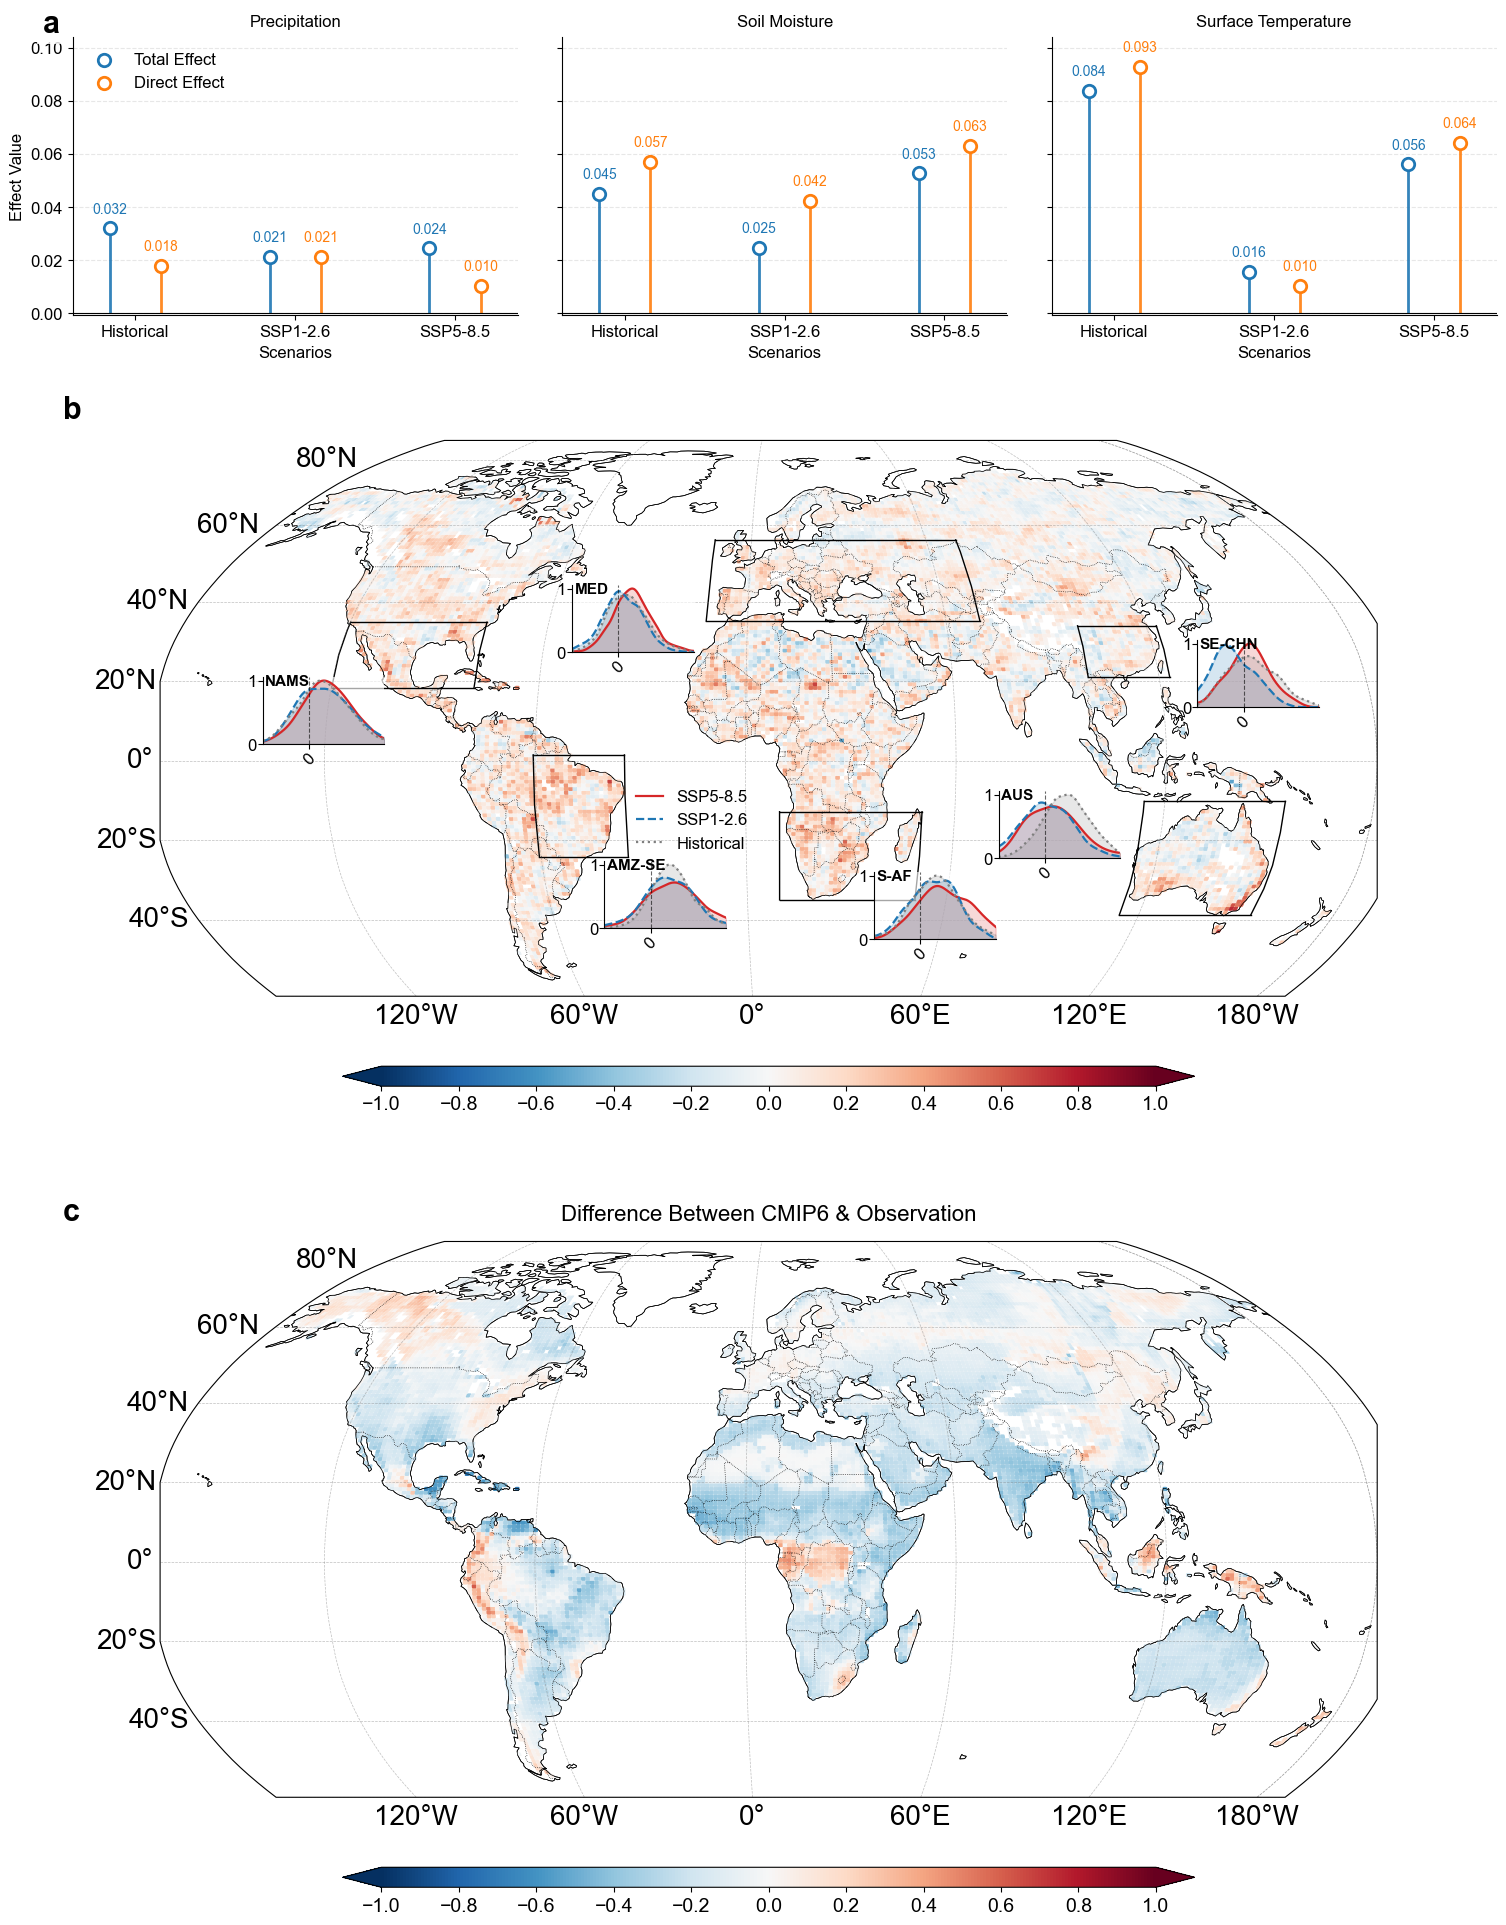

In [5]:
def create_supplementary_fig20():
    # 重置matplotlib默认样式，避免全局设置干扰
    plt.rcParams.update(plt.rcParamsDefault)
    # 明确设置子图背景色和边框默认值
    plt.rcParams['axes.facecolor'] = 'white'       # 子图背景白色
    plt.rcParams['axes.edgecolor'] = 'black'       # 边框默认黑色
    plt.rcParams.update({
        'font.family': 'serif',           # 主字体类型（serif衬线 / sans-serif无衬线）
        'font.serif': ['Arial'], # 衬线字体首选
        'font.sans-serif': ['Times New Roman'],      # 无衬线字体备选
    })

    # 创建图形和子图布局
    fig = plt.figure(figsize=(16, 20))

    # 创建2x1的子图布局（根据实际需求调整）
    gs = gridspec.GridSpec(3, 1, figure=fig, height_ratios=[3, 6, 6], wspace=0.07, hspace=0.4, top=0.95, bottom=0.07, left=0.1, right=0.99)

    # 第二个子图（图5b）
    ax2 = fig.add_subplot(gs[0, :])
    mesh2 = plot_supplementary_fig20b(fig, ax2)

    # 第三个子图（图5c）
    ax3 = fig.add_subplot(gs[1, :], projection=ccrs.Robinson(central_longitude=10))
    mesh3 = plot_supplementary_fig20c(fig, ax3)

    # 第一个子图（图5a）
    ax1 = fig.add_subplot(gs[2, :], projection=ccrs.Robinson(central_longitude=10))
    mesh1 = plot_supplementary_fig20a(fig, ax1)

    plt.show()


if __name__ == '__main__':
    create_supplementary_fig20()